In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import zscore
from scipy import signal

In [67]:
import matplotlib

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams["font.size"] = 12
colors = ["#000000", "#e3a765"]
sns.set_palette(sns.color_palette(colors))

In [58]:
fig_dir = r"C:\Users\Rory\Google Drive\ah_vids\PL-BLA\freeze_analysis\figures\crosscorrelation"
dataset = r"C:\Users\Rory\Google Drive\ah_vids\PL-BLA\freeze_analysis\conditioning_reports\PLBLA_tidy.csv"

In [59]:
fig_dir = Path(fig_dir)
df = pd.read_csv(dataset)

In [60]:
def cross_correlation(s1, s2, num_lags=None, 
                      standardise=False, standardise_range="all"):
    out = signal.correlate(s1, s2, mode="same")
    if standardise and standardise_range=="all":
        out = zscore(out)
    if num_lags:
        zero_idx = len(out) // 2
        out = out[zero_idx-num_lags:zero_idx+num_lags+1]
    if standardise and standardise_range=="sub":
        out = zscore(out)
    return out

def cc_lags(cc, interval):
    num_lags = len(cc) // 2
    return np.arange(-num_lags, (num_lags + 1)) * interval

def corss_corr_by(x, num_lags=300, standardise=False, standardise_range="all"):
    fps = x.iloc[0].fps
    dem = x.was_freezing_dem.values
    obs = x.was_freezing_obs.values
    zcc = cross_correlation(dem, obs, num_lags=num_lags, standardise=standardise,
                           standardise_range=standardise_range)
    lags = cc_lags(zcc, 1/fps)
    return pd.DataFrame({
        "lag": lags,
        "cc": zcc,
        })

In [220]:
def crosscorrelation_by(
    df, 
    num_lags, 
    session_col,
    trial_col=None,
    group_col=None,
    block_col=None,
    first_x_trials=None,
    last_x_trials=None,
    first_x_secs=None,
    last_x_secs=None,
    standardise=True,
    round_to_sec=True,
    standardise_range="sub",
    latency_col="aligned",
):
    groupby_cols = [session_col]
    if group_col:
        groupby_cols.append(group_col)
    if block_col:
        groupby_cols.append(block_col)
    if trial_col:
        groupby_cols.append(trial_col)
    if first_x_trials:
        if not trial_col:
            raise ValueError("trial_col not passed")
        df = df.loc[lambda x: x[trial_col] <= first_x_trials]
    if last_x_trials:
        if not trial_col:
            raise ValueError("trial_col not passed")
        df = df.loc[lambda x: x[trial_col] >= (x[trial_col].max() - last_x_trials)]
    if first_x_secs:
        df = df.loc[lambda x: x[latency_col] < first_x_secs]
    if last_x_secs:
        block_maxes = df.groupby(block_col)[latency_col].max().reset_index().rename(columns={latency_col: "max_lat"})
        df = (
            df
            .merge(block_maxes)
            .loc[lambda x: (x["max_lat"] -  x[latency_col]) < last_x_secs]
            .drop("max_lat", axis=1)
        )
    
    df_out = (
        df
        .groupby(groupby_cols)
        .apply(
            lambda x: corss_corr_by(
                x, 
                standardise=standardise,
                num_lags=num_lags,
                standardise_range=standardise_range)
        )
        .reset_index()
    )
    # get average cc value at each second
    if round_to_sec:
        df_out = (
            df_out
            .pipe(lambda x: x.groupby([*groupby_cols, np.round(x["lag"])]))
            .mean()
            .drop("lag", axis=1)
            .reset_index()
        )
    df_out = df_out[[col for col in df_out.columns if not col.startswith("level_")]]
    return df_out

def crosscorrelation_plot(df, x="lag", y="cc", hue=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax = sns.lineplot(
        data=df, 
        x=x,
        y=y,
        hue=hue,
        ax=ax
    )
    ax.axhline(0, linestyle="dashed", color="grey")
    ax.axvline(0, linestyle="dashed", color="grey")
    sns.despine()
    ax.set_ylabel("$Z_{cc}$", fontsize=12)
    ax.set_xlabel("Lag", fontsize=12)
    plt.tight_layout()
    return ax


## Whole Session

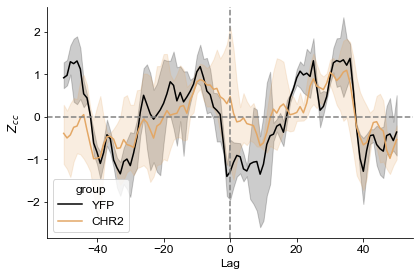

In [281]:
df_cc_session2 = crosscorrelation_by(df, 
                                     num_lags=500,
                                     group_col="group", 
                                     session_col="video_name")

crosscorrelation_plot(df_cc_session2, hue="group")
plt.savefig(fig_dir / "whole_session.svg")

## By Block Type

In [248]:
cc_blocks_notrials = crosscorrelation_by(
    df, 
    num_lags=299,
    group_col="group",
    block_col="block_type",
    session_col="video_name"
).dropna()

cc_blocks = crosscorrelation_by(
    df, 
    num_lags=299,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name"
).dropna()

us = crosscorrelation_by(
    df, 
    num_lags=19,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    last_x_secs=2,
).dropna().loc[lambda x: x.block_type== "CS"]

c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


#### Baseline

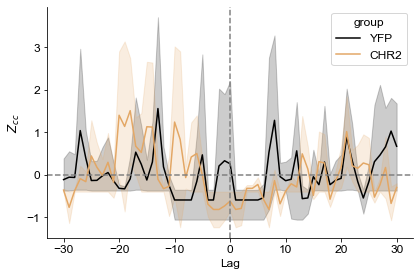

In [282]:
baseline = cc_blocks_notrials.loc[lambda x: x.block_type == "Baseline"]
crosscorrelation_plot(baseline, hue="group")
plt.savefig(fig_dir / "baseline.svg")

#### Post Experiment

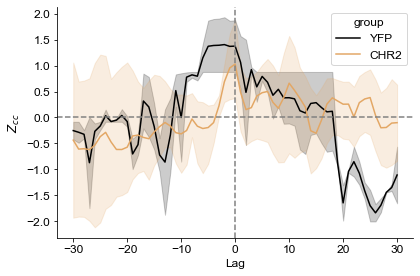

In [283]:
post = cc_blocks_notrials.loc[lambda x: x.block_type == "PostExperiment"]
crosscorrelation_plot(post, hue="group")
plt.savefig(fig_dir / "post_experiment.svg")

#### CS

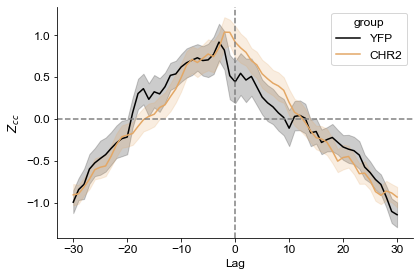

In [284]:
cs = cc_blocks.loc[lambda x: x.block_type == "CS"]
crosscorrelation_plot(cs, hue="group")
plt.savefig(fig_dir / "cs.svg")

#### ITI

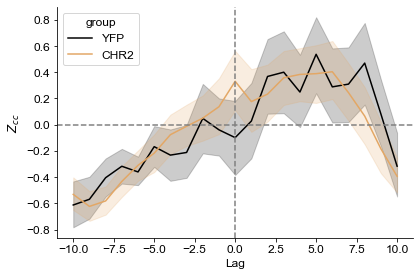

In [285]:
iti = cc_blocks.loc[lambda x: x.block_type == "ITI"]
crosscorrelation_plot(iti, hue="group")
plt.savefig(fig_dir / "iti.svg")

#### US

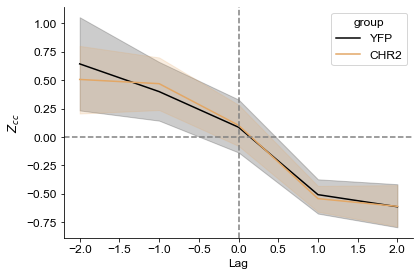

In [286]:
crosscorrelation_plot(us_blocks, hue="group")
plt.savefig(fig_dir / "us.svg")

## Frist 5 Trials

In [249]:
cc_blocks_fft = crosscorrelation_by(
    df, 
    num_lags=299,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    first_x_trials=5
).dropna()

us_fft = crosscorrelation_by(
    df, 
    num_lags=19,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    first_x_trials=5,
    last_x_secs=2,
).dropna().loc[lambda x: x.block_type== "CS"]

c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


#### CS

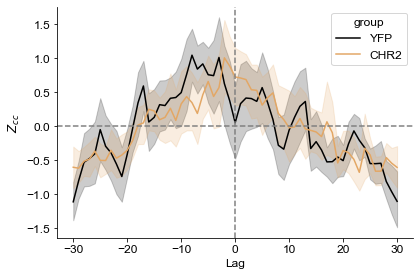

In [287]:
cs = cc_blocks_fft.loc[lambda x: x.block_type == "CS"]
crosscorrelation_plot(cs, hue="group")
plt.savefig(fig_dir / "first5_trials_cs.svg")

#### ITI

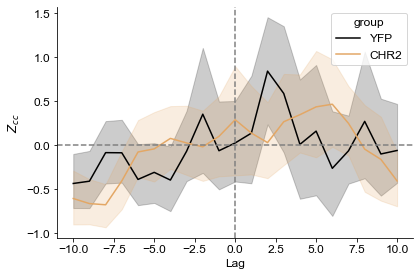

In [288]:
iti = cc_blocks_fft.loc[lambda x: x.block_type == "ITI"]
crosscorrelation_plot(iti, hue="group")
plt.savefig(fig_dir / "first5_trials_iti.svg")

#### US

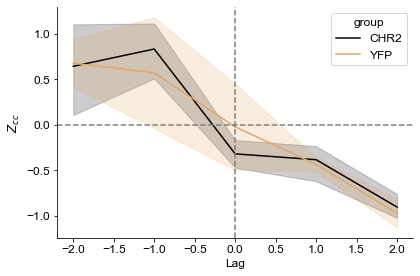

In [289]:
crosscorrelation_plot(us_fft, hue="group")
plt.savefig(fig_dir / "first5_trials_us.svg")

## Last 5 Trials

In [290]:
cc_blocks_lft = crosscorrelation_by(
    df, 
    num_lags=299,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    last_x_trials=5
).dropna()

us_blocks_lft = crosscorrelation_by(
    df, 
    num_lags=19,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    last_x_trials=5,
    last_x_secs=2,
).dropna().loc[lambda x: x.block_type== "CS"]

c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


#### CS

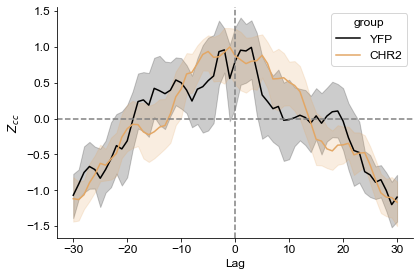

In [291]:
cs = cc_blocks_lft.loc[lambda x: x.block_type == "CS"]
crosscorrelation_plot(cs, hue="group")
plt.savefig(fig_dir / "last5_trials_cs.svg")

#### ITI

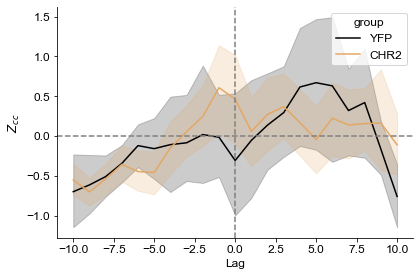

In [292]:
iti = cc_blocks_lf.loc[lambda x: x.block_type == "ITI"]
crosscorrelation_plot(iti, hue="group")
plt.savefig(fig_dir / "last5_trials_iti.svg")

#### US

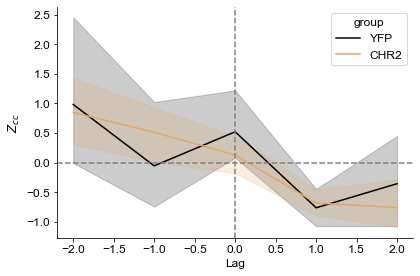

In [293]:
crosscorrelation_plot(us_blocks_lft, hue="group")
plt.savefig(fig_dir / "last5_trials_us.svg")

## First 5 Seconds

In [294]:
cc_blocks_ffs = crosscorrelation_by(
    df, 
    num_lags=49,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    first_x_secs=5
).dropna()

c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


#### CS

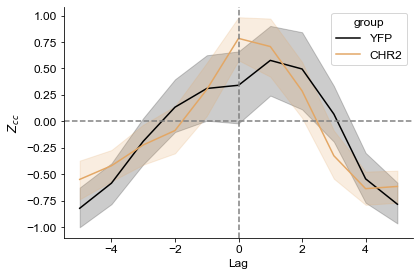

In [295]:
cs = cc_blocks_ffs.loc[lambda x: x.block_type == "CS"]
crosscorrelation_plot(cs, hue="group")
plt.savefig(fig_dir / "first5_secs_cs.svg")

#### ITI

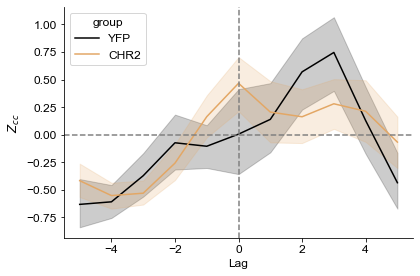

In [296]:
iti = cc_blocks_ffs.loc[lambda x: x.block_type == "ITI"]
crosscorrelation_plot(iti, hue="group")
plt.savefig(fig_dir / "first5_secs_iti.svg")

## Last 5 Seconds

In [297]:
cc_blocks_lfs = crosscorrelation_by(
    df, 
    num_lags=49,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    last_x_secs=5
).dropna()

c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


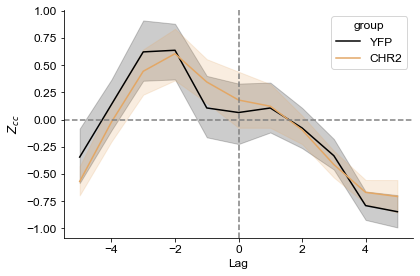

In [299]:
cs = cc_blocks_lfs.loc[lambda x: x.block_type == "CS"]
crosscorrelation_plot(cs, hue="group")
plt.savefig(fig_dir / "last5_secs_cs.svg")

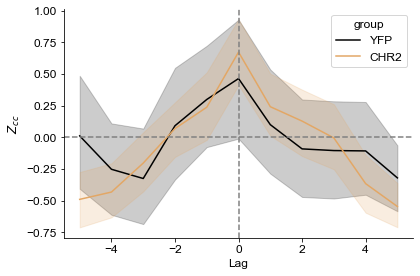

In [300]:
iti = cc_blocks_lfs.loc[lambda x: x.block_type == "ITI"]
crosscorrelation_plot(iti, hue="group")
plt.savefig(fig_dir / "last5_secs_iti.svg")

## First 5 Trials First 5 Secs

In [301]:
cc_blocks_fft_ffs = crosscorrelation_by(
    df, 
    num_lags=49,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    first_x_secs=5,
    first_x_trials=5
).dropna()

c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


#### CS

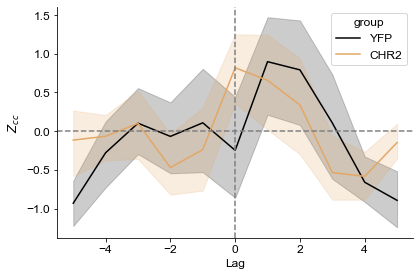

In [302]:
cs = cc_blocks_fft_ffs.loc[lambda x: x.block_type == "CS"]
crosscorrelation_plot(cs, hue="group")
plt.savefig(fig_dir / "first5_trials_first5_secs_cs.svg")

#### ITI

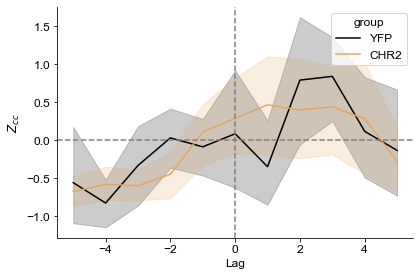

In [303]:
iti = cc_blocks_fft_ffs.loc[lambda x: x.block_type == "ITI"]
crosscorrelation_plot(iti, hue="group")
plt.savefig(fig_dir / "first5_trials_first5_secs_iti.svg")

## First 5 Trials Last 5 Secs

In [304]:
cc_blocks_fft_lfs = crosscorrelation_by(
    df, 
    num_lags=49,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    last_x_secs=5,
    first_x_trials=5
).dropna()

c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


#### CS

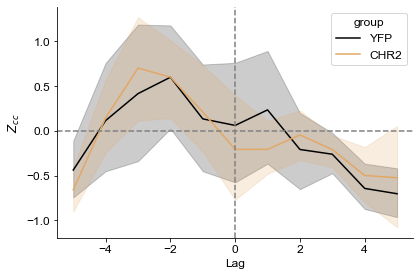

In [305]:
cs = cc_blocks_fft_lfs.loc[lambda x: x.block_type == "CS"]
crosscorrelation_plot(cs, hue="group")
plt.savefig(fig_dir / "first5_trials_last5_secs_cs.svg")

#### ITI

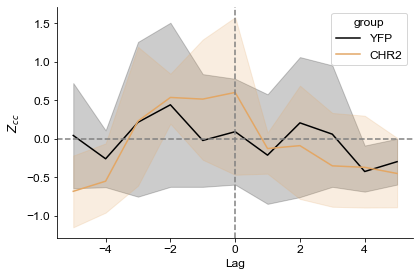

In [306]:
iti = cc_blocks_fft_lfs.loc[lambda x: x.block_type == "ITI"]
crosscorrelation_plot(iti, hue="group")
plt.savefig(fig_dir / "first5_trials_last5_secs_iti.svg")

## Last 5 Trials First 5 Secs

In [307]:
cc_blocks_lft_ffs = crosscorrelation_by(
    df, 
    num_lags=49,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    first_x_secs=5,
    last_x_trials=5
).dropna()

c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


#### CS

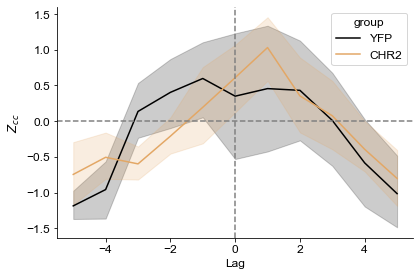

In [308]:
cs = cc_blocks_lft_ffs.loc[lambda x: x.block_type == "CS"]
crosscorrelation_plot(cs, hue="group")
plt.savefig(fig_dir / "last5_trials_first5_secs_cs.svg")

#### ITI

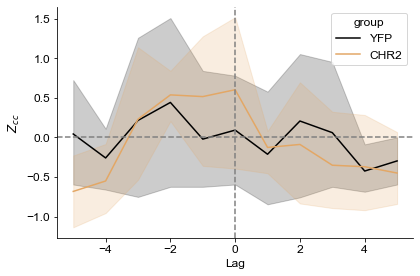

In [309]:
iti = cc_blocks_fft_lfs.loc[lambda x: x.block_type == "ITI"]
crosscorrelation_plot(iti, hue="group")
plt.savefig(fig_dir / "last5_trials_first5_secs_iti.svg")

## Last 5 Trials Last 5 Secs

In [310]:
cc_blocks_lft_lfs = crosscorrelation_by(
    df, 
    num_lags=49,
    group_col="group",
    block_col="block_type",
    trial_col="trial_num",
    session_col="video_name",
    last_x_secs=5,
    last_x_trials=5
).dropna()

c:\users\rory\miniconda3\envs\ofl\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


#### CS

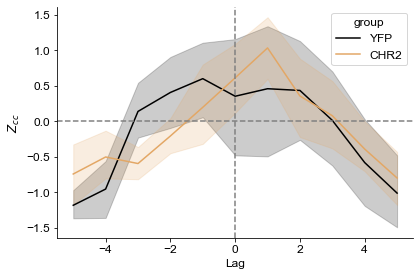

In [312]:
cs = cc_blocks_lft_ffs.loc[lambda x: x.block_type == "CS"]
crosscorrelation_plot(cs, hue="group")
plt.savefig(fig_dir / "last5_trials_last5_secs_cs.svg")

#### ITI

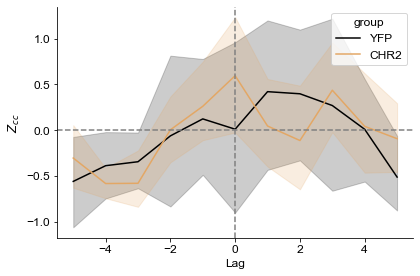

In [313]:
iti = cc_blocks_lft_ffs.loc[lambda x: x.block_type == "ITI"]
crosscorrelation_plot(iti, hue="group")
plt.savefig(fig_dir / "last5_trials_last5_secs_iti.svg")